@author ArturoSirvent


# Outline

La idea de esta implementación es aprovechar la información que tenemos de las tensiones, para hacer la estimación de los parámetros. El problema con la eq del equilibrio, es que no involubra lo suficiente a E. Mientras que en las condiciones de contorno, si que estamos introduciendo esa condición.

Voy a tomar todos los datos de los que tenemos tensiones (que creo que solo son los de la superficie), y sus esplazamientos y posiciones iniciales, y con ellos, vamos a entrenar una red que tenga de output desplazamiento y tension.   

Para este entrenamiento, voy a tener la función de perdida de la data + la función de pérdida de PDE que tendrá dos partes, la de equilibrio, y la de ecuación constitutiva, es decir la epsilon calculada con los desplazamientos x C, y la sigma obtenida por la red, deben coincidir.  

Por último, las condiciones de contorno es imponer la invovilidad de los nodos quietos (condiciones de Dirichlet) e imponer las tensiones: ¿**Las tensiones las impongo en la zona donde se aplica la fuerza, o como**?  ¿**Mejor forma de informar a la red de los nodos recibidores de la fuerza**?

Vamos a trabajar solo con los puntos de la superficie.   

¿**Hay algún motivo por el cual no hay en el interior tensiones**?

### Ideas extra  

- Que los outputs no sean directamente el valor, que pasen por un escalado, o una función que les impone unas restricciones extra. (paper del contacto) Esto creo que viene por la forma de exprear una eq diferencial en forma residual...
Esta es una 'user defined transformation', que nos permite meterle hard constrains. 
- El tema del escalado segun el valor de E. O el escalado de los outputs para que haya un equilibrio en la función de pérdida.  

- El tema del pesado de los términos de la loss. 


In [1]:
#librerias

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import random
import json 
import time
import plotly.express as px
from dataclasses import dataclass      
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [2]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False
    

#vamos a hacer una función para cargar todos los datos de una   
@dataclass
class Data:
    folder: str
    load_stage: int
    base_dir:str = "/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
    E: str = None
    initialPosition_data_pd: pd.DataFrame =None
    stress_data_pd: pd.DataFrame =None
    displacement_data_pd: pd.DataFrame=None
    restricted_data_pd: pd.DataFrame =None
    force_data_pd: pd.DataFrame =None 
    final_data_pd: pd.DataFrame =None
    collocation_data_np:pd.DataFrame =None
    Pos_min: np.ndarray = None
    Pos_max: np.ndarray = None
    adjancet_matrix: np.ndarray=None

    @classmethod
    def keep_line(line):
        line_split=line.split()
        try:
            int(line_split[0])
            #si no dio error, okey entra
            return True
        except:
            return False

    def load_data(self,load_stage=10,normalize_pos=False):
        # carga las posiciones de los nodos    
        initialPosition_data_path = f"{self.base_dir}/ARTURO_TEST_1/NODES.txt"

        with open(initialPosition_data_path,"r") as f:
            aux_list=f.readlines()

        initialPosition_data=[i for i in aux_list if keep_line(i)]
        initialPosition_data=[i.strip("\n") for i in initialPosition_data]
        initialPosition_data=[i.split() for i in initialPosition_data]
        initialPosition_data_np=np.array(initialPosition_data).astype(float)[:,[0,1,2,3]]
        self.initialPosition_data_pd=pd.DataFrame(initialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
        self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
        self.Pos_max=self.initialPosition_data_pd.max().to_numpy()

        #noramlizamos las posiciones 
        if normalize_pos:
            self.initialPosition_data_pd=(self.initialPosition_data_pd-self.initialPosition_data_pd.min())/(self.initialPosition_data_pd.max()-self.initialPosition_data_pd.min())

        #carga el streess
        if self.E is not None:
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES_E{self.E}.txt"
        else: 
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"
        with open(stress_data_path,"r") as f:
            aux_list=f.readlines()


        stress_data=[i for i in aux_list if keep_line(i)]
        stress_data=[i.strip("\n").strip() for i in stress_data]
        patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

        stress_data=[re.findall(patron,i) for i in stress_data]
        stress_data=np.array(stress_data,dtype=float)
        self.stress_data_pd=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")[["SX","SY","SZ","SYZ","SXZ","SXY"]] # lo queremos asi : s11,s22,s33,s23,s13,s12

        # cargar datos de desplazamiento  
        if self.E is not None:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP_E{self.E}.txt"
        else:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP.txt"

        with open(displacement_data_path,"r") as f:
            aux_list=f.readlines()


        displacement_data=[i for i in aux_list if keep_line(i)]
        displacement_data=[i.strip("\n").strip() for i in displacement_data]
        patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

        displacement_data=[re.findall(patron,i) for i in displacement_data]
        displacement_data=np.array(displacement_data,dtype=float)
        self.displacement_data_pd=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

        # cargar datos de boundaries en el movimiento
        #cargar los nodos fijos
        with open(f"{self.base_dir}/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
            restricted_data=f.readlines()

        restricted_data=[i for i in restricted_data if keep_line(i)]
        restricted_data=[i.strip("\n") for i in restricted_data]
        restricted_data=[i.split() for i in restricted_data]
        restricted_data_np=np.array(restricted_data)[:,[0,1]]
        self.restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
        self.restricted_data_pd=self.restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
        self.restricted_data_pd.index=self.restricted_data_pd.index.astype(int)
        self.restricted_data_pd=self.restricted_data_pd.sort_index()
        self.restricted_data_pd=self.restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

        with open(f"{self.base_dir}/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
            force_data=f.readlines()


        force_data=[i for i in force_data if keep_line(i)]
        force_data=[i.strip("\n") for i in force_data]
        force_data=[i.split() for i in force_data]
        force_data_np=np.array(force_data)[:,[0,1,2]]
        self.force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
        self.force_data_pd["Fuerza"]=self.force_data_pd["Fuerza"].astype(float)
        self.force_data_pd=self.force_data_pd.set_index("Node")
        self.force_data_pd.index=self.force_data_pd.index.astype(int)


        #ponemos todos los datos en común usando los nodos como clave   
        self.final_data_pd=self.initialPosition_data_pd.merge(self.stress_data_pd,left_index=True,right_index=True,how="left").merge(self.force_data_pd,left_index=True,right_index=True,how="left").merge(self.displacement_data_pd,left_index=True,right_index=True,how="left").merge(self.restricted_data_pd,left_index=True,right_index=True,how="left")

        self.final_data_pd["Final_X"]=self.final_data_pd["X"]-self.final_data_pd["UX"]
        self.final_data_pd["Final_Y"]=self.final_data_pd["Y"]-self.final_data_pd["UY"]
        self.final_data_pd["Final_Z"]=self.final_data_pd["Z"]-self.final_data_pd["UZ"]

    def create_colloc_points(self,n_colloc=70000,colloc_type="random_2"):

        if colloc_type=="random_1":

            X_coloc = np.random.uniform(self.Pos_min[0], self.Pos_max[0], (n_colloc, 1))
            Y_coloc = np.random.uniform(self.Pos_min[1], self.Pos_max[1], (n_colloc, 1))
            Z_coloc = np.random.uniform(self.Pos_min[2], self.Pos_max[2], (n_colloc, 1))
            self.collocation_data_np = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
            

        
        elif colloc_type=="random_2":
            #este tipo de random es una distribucion por todo el espacio para cada punto
            points=[]
            for _ in range(n_colloc):
                X_coloc_aux = np.random.uniform(self.Pos_min[0], self.Pos_max[0], 1)
                Y_coloc_aux = np.random.uniform(self.Pos_min[1], self.Pos_max[1], 1)
                Z_coloc_aux = np.random.uniform(self.Pos_min[2], self.Pos_max[2], 1)
                points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

            self.collocation_data_np = np.array(points).reshape(-1, 3)


    def prepare_pytorch_data(self,n_colloc=70000,colloc_type="random_2",percentage_stress_data=0.8,train_percent=0.8):
        #para el entrenamiento necesitamos diferentes conjuntos de datos

        # 1. los datos experimentales que saldrán de los datos sin limitaciones de movimiento
        # pero no haremos ninguna diferenciación más, los que tengan una fuerza aplicada nos da igual
        # lo tomamos también

        # 1.1. Otro set de datos que son los que tienen limitaciones totales del movimiento
        # 1.2. Otro que será los que tengan limitaciones direccionales del movimiento

        # estos dos anteriores, simplemente tienen desplamiento nulo en las direcciones que correspondan
        # por eso lo vamos a meter con los datos normales, pero si quisieramos darles mayor importancia
        # podríamos tenerlos en un término a parte den la funcion de perdida.   

        # 2. Los collocation points, esto son x,y,z repartidas por todo el dominio que nos interese  


        # 3. Las BC. Aquí entran las NBC, y en el futuro la DBC de antes. Antes imponíamos solo donde estaba
        # aplicada la fuerza, pero esto no tiene porque ser así, es más, estamos muy limitados si así es. Si solo quisiéramos 
        # darle información de la Fuerza, habría que ver otra manera creo yo. Por ahora, le voy a dar todos o un subconjunto de los 
        # puntos y valores de sigma en la superficie, para que lo tenga como referencia para aprender la fisica y hacer bien los
        # desplazamientos.

        # Los datos de test será sacados del conjunto de datos no restringidos de desplazamientos

        # El tema de la normalizacion: ----


        # colloc points
        if self.collocation_data_np is None:
            self.create_colloc_points(n_colloc=n_colloc,colloc_type=colloc_type)
        return_colloc_points=torch.tensor(self.collocation_data_np,requires_grad=True)

        # desp_data, tanto los limitados como el resto  

        # no limitados, separamos en 80 y 20
        indx_non_restricted=[int(i) for i in self.displacement_data_pd.index if i not in self.restricted_data_pd.index ]
        random.shuffle(indx_non_restricted)
        self.indx_train_non_restricted,self.indx_test_non_restricted = indx_non_restricted[:int(len(indx_non_restricted)//(1/train_percent))], indx_non_restricted[int(len(indx_non_restricted)//(1/train_percent)):]
        
        train_init_pos_non_restricted, train_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_train_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_train_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)
        test_init_pos_non_restricted, test_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_test_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_test_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        # limitados
        initpos_restricted_data=torch.tensor(self.initialPosition_data_pd.loc[self.restricted_data_pd.index,["X","Y","Z"]].to_numpy(),requires_grad=True)

        disp_restricted_data=torch.tensor(self.displacement_data_pd.loc[self.restricted_data_pd.index,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        train_init_pos_main,train_disp_main=torch.concat([train_init_pos_non_restricted,initpos_restricted_data]),torch.concat([train_disp_non_restricted,disp_restricted_data])
        test_init_pos_main,test_disp_main=test_init_pos_non_restricted, test_disp_non_restricted

        #los indices los tenemos trazados:   

        self.index_train=list(self.indx_train_non_restricted) + self.restricted_data_pd.index.to_list() 
        self.index_test=list(self.indx_test_non_restricted)
        # data del NCB
        # voy a escoder un pocentaje de datos de estos de los que dar.
        selected_stresses=self.stress_data_pd.sample(frac=percentage_stress_data,axis=0)
        self.index_stress=selected_stresses.index.to_list()
        position_selected_stresses=torch.tensor(self.initialPosition_data_pd.loc[selected_stresses.index].to_numpy(),requires_grad=True)
        return_stress=torch.tensor(selected_stresses.to_numpy(),requires_grad=True)
        # si quisieramos hacer una separacion
        #from sklearn... import train_test_split
        #train_test_split(self.stress_data_pd.to_numpy())

        return train_init_pos_main.float(),train_disp_main.float(),test_init_pos_main.float(),test_disp_main.float(),position_selected_stresses.float(),return_stress.float(),return_colloc_points.float()


In [3]:
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005")
data.load_data()

In [4]:
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()

In [5]:
train_disp_main.max(axis=0)

torch.return_types.max(
values=tensor([4.6197, 0.0000, 7.3187], grad_fn=<MaxBackward0>),
indices=tensor([1949, 2794,  774]))

In [6]:
# Red neuronal  

class DNN(nn.Module):
    def __init__(self,layers,init_w="xavier"):
        super().__init__() 
        self.layers=layers
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        if init_w=="xavier":
            #Xavier Normal Initialization
            for i in range(len(layers)-1):
                nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
                
                # set biases to zero
                nn.init.zeros_(self.linears[i].bias.data)
        # elif init_w=="gorot":
        #         nn.init. (self.linears[i].weight.data, gain=1.0)
                
        #         # set biases to zero
        #         nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        #xn = normalize(x, Pos_min, Pos_max)

        # convert to float
        a = x.float()
        

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            z = self.linears[i](a)          
            a = self.activation(z)

        # output layer forward computation            
        b = self.linears[-1](a)
        
        return b

In [7]:
class PINN_mixedForm(DNN):
    '''
        Esta clase hace el registro de todos los parámetros, los cálculos de derivadas y de losses
        Y aplica las restricciones que hagan falta

        Esto será la aprox mixta con el primero el desplazamiento y el segungo la tensión (realmente son 6 componentes).
    '''
    def __init__(self, layers,init_values=None,device=None,separate_data_losses=True,loss_weights={"Data":1,"PDE":1,"BC":1,"EC":1}):
        super().__init__(layers)
        
        if device is None:
            self.device= "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device=device
        self.to(self.device)


        #History of losses
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "EC":[],
                             "Total":[]}
         #Parameters trials
        self.params_history = { "E": [] ,
                                "alpha": []}

        #inicialización de parametros
        self.nu = init_values[0]
        self.alpha = nn.Parameter(torch.tensor(init_values[2],dtype=torch.float32).to(self.device))
        self.E_ref = init_values[1]
        self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)
        self.separate_data_losses=separate_data_losses
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.w_data=loss_weights["Data"]
        self.w_PDE=loss_weights["PDE"]
        self.w_BC=loss_weights["BC"]
        self.w_EC=loss_weights["EC"]
        self.iter_n=0

    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone().to(self.device)
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1).to( self.device )
        # Compute the output of the DNN
        U = self(XYZ)
        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)
        return u, v, w, U[:,3:]
    # Los cálculos de las funciones de pérdida de hacen 1 vez, y luego ya vemos que hacemos
    # con esos datos, si usar pesos, si usar otras cosas...

    def loss_PDE(self, collocation_points, save = True):
        # estos son los puntos en los que imponemos las leyes físicas  
        # puede ser la ecuación de equilibrio, pero también pueden ser otras relaciones
        # que conozcamos entre inputs y outputs, como por ejemplo, relaciones termodinámicas etc..
        # si el output fuera posicion y tensión, entonces podriamos imponer la ley de hooke sobre este
        # input.
        collocation_points=collocation_points.to(self.device)
        X, Y, Z = self.compute_XYZ(collocation_points)
        u, v, w,_ = self.compute_displacements(X,Y,Z)


        # y ahora tenemos que obtener las derivadas necesarias para aplicar la eq de equilibrio
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon)
        div_sigma = self.divergence(sigma,X, Y, Z)

        value_loss_PDE=self.loss_function(div_sigma,torch.zeros_like(div_sigma).to(self.device))
        
        if save:
            self.loss_history["PDE"].append(value_loss_PDE.item())#.to('cpu').detach().numpy())
        
        return value_loss_PDE
    
    def loss_BC(self,pos_reales,sigmas_reales,save=True):
        #aqui tenemos las de Dirichlet y las de Neumann
        # en mi caso que no hay contacto ni nada, pero si tengo nodos fijos!! las de Dirichlet tbn

        #en esta implementación voy a imponer las sigmas solo aqui, en una futura, podría meter también
        #las de Dirichlet para poder darles mas peso

        #calculamos sobre las posiciones de las sigmas que tenemos, las dadas por el modelo
        # predict U
        X,Y,Z=self.compute_XYZ(pos_reales)
        u, v, w,_=self.compute_displacements(X,Y,Z)
        
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon) 
        #este sigma tiene primera dimension batchsize, y segunda dimension 6
        #que corresponde con: s11,s22,s33,s23,s13,s12
        #le imponemos que sean iguales de modo que aplicamos la loss y ya
        value_loss_BC=self.loss_function(sigma,sigmas_reales.to(self.device))

        if save:
            self.loss_history["BC"].append(value_loss_BC.item())#.to('cpu').detach().numpy())

        return value_loss_BC

    #def loss_DBC(fix_nodes)
    #   pass

    def loss_data(self, pos_reales,desp_reales,save=True):
        desp_reales=desp_reales.to(self.device)
        u_predict=self(pos_reales.to(self.device))[:,:3]
        if self.separate_data_losses:
            sepatared_loss=torch.nn.MSELoss(reduction="none")
            #aux=self.loss_function(u_predict,desp_reales)
            #esto nos devuelve la diferencia cuadrática de cada elemento, para evaluarlos por
            #separado, vamos a hacer la media en columnas
            # x_mse,y_mse,z_mse=torch.mean(aux,axis=0)
            # x_mse,y_mse,z_mse=torch.sqrt(x_mse),torch.sqrt(y_mse),torch.sqrt(z_mse)
            value_loss_data=torch.mean(torch.sqrt(torch.mean(sepatared_loss(u_predict,desp_reales),axis=0)))
        else:
            value_loss_data=self.loss_function(u_predict,desp_reales)

        if save:
            self.loss_history["Data"].append(value_loss_data.item())#.to('cpu').detach().numpy())
        
        return value_loss_data
    

    def loss_ConstEq(self, pos_colloc,save=True):

        X,Y,Z=self.compute_XYZ(pos_colloc)
        u, v, w,sigma_pred=self.compute_displacements(X,Y,Z)
        
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon) #s11,s22,s33,s23,s13,s12  
        value_loss_ConstEq=self.loss_function(sigma,sigma_pred)
        if save:
            self.loss_history["EC"].append(value_loss_ConstEq.item())#.to('cpu').detach().numpy())

        return value_loss_ConstEq

    
    def loss(self, pos_data,desp_data,pos_colloc,pos_BC,sigmas_BC,save=True):
        #esto hace que se calculen todas las losses de la pinn
        #además, si tenemos un parámetro E, este se actualizará, pe si estamos actualizando alpha en lugar
        #de E, despues de la recalculación tendremos que actualizar E. 

        #actualizamos E antes de calcular nada

        self.E=(1+self.alpha)*self.E_ref

        value_loss_PCE=self.loss_PDE(pos_colloc,save=save)
        value_loss_BC=self.loss_BC(pos_BC,sigmas_BC,save=save)
        value_loss_data=self.loss_data(pos_data,desp_data,save=save) 
        value_loss_ConstEq=self.loss_ConstEq(pos_colloc,save=save)

        value_loss= self.w_data*value_loss_data + self.w_PDE*value_loss_PCE+ self.w_BC*value_loss_BC + self.w_EC*value_loss_ConstEq


        if save: 
            #self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').detach().numpy())
            self.params_history["alpha"].append(self.alpha.to('cpu').detach().numpy())
            self.loss_history["Total"].append(value_loss.item())#.to('cpu').detach().numpy())

        return value_loss

    def compute_gradU(self, X, Y, Z, U, V, W):

        # Compute the gradient of U
        Ux,Uy,Uz = autograd.grad(U, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Uy = autograd.grad(U, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Uz = autograd.grad(U, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx,Vy,Vz = autograd.grad(V, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Vy = autograd.grad(V, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Vz = autograd.grad(V, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of W
        Wx,Wy,Wz = autograd.grad(W, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Wy = autograd.grad(W, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Wz = autograd.grad(W, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_strain(self, X,Y,Z,u, v, w):
        # Compute strain components using autograd
        nabla_U = self.compute_gradU(X,Y,Z,u, v, w).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))
        return strain


    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(self.device)
        #strain_flat=strain[:,(0,1,2,0,0,1),(0,1,2,1,2,2)] # e00,e11,e22,e01,e02,e12
        self.C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).float().to(self.device)

        return torch.matmul(self.C,strain_flat.T.float()).T.squeeze() #s11,s22,s33,s23,s13,s12

    def divergence(self,sigma, X, Y, Z):
        div_T = torch.zeros(sigma.shape[0],3).to(self.device)
        div_T[:,0]=autograd.grad(sigma[:,0],X,grad_outputs=torch.ones_like(sigma[:,0]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,5],Y,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,4],Z,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,1]=autograd.grad(sigma[:,5],X,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,1],Y,grad_outputs=torch.ones_like(sigma[:,1]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Z,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,2]=autograd.grad(sigma[:,4],X,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Y,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,2],Z,grad_outputs=torch.ones_like(sigma[:,2]).to(self.device),retain_graph=True)[0].squeeze()

        return div_T
    

    def step_closure(self,opt,train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2):
        
        opt.zero_grad()
        
        loss = self.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
        
        loss.backward()
        self.iter_n+=1
        # Print material parameters and loss evolition
        print(f'LBFGS iter: {self.iter_n}, Loss: {loss.item()}')
            
        
        return loss


In [8]:
pinn=PINN_mixedForm([3,20,20,20,20,20,20,20,9],[0.4,0.001,0.1],loss_weights={"Data":2,"PDE":1e6,"BC":1e3,"EC":1e3})

opt=torch.optim.Adam(pinn.parameters(),lr=1e-3)
for epoch in range(2000):
    loss=pinn.loss(train_init_pos_main.to(float),train_disp_main,return_colloc_points,position_selected_stresses,return_stress)
    print("Epoch: ", epoch, "loss: ", loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

/tmp/ipykernel_63787/589368763.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)


Epoch:  0 loss:  110.54852294921875
Epoch:  1 loss:  62.80204391479492
Epoch:  2 loss:  34.99412155151367
Epoch:  3 loss:  24.53439712524414
Epoch:  4 loss:  25.212326049804688
Epoch:  5 loss:  29.372177124023438
Epoch:  6 loss:  31.801193237304688
Epoch:  7 loss:  30.935131072998047
Epoch:  8 loss:  27.542877197265625
Epoch:  9 loss:  23.188383102416992
Epoch:  10 loss:  19.260713577270508
Epoch:  11 loss:  16.514305114746094
Epoch:  12 loss:  15.012816429138184
Epoch:  13 loss:  14.386090278625488
Epoch:  14 loss:  14.18165397644043
Epoch:  15 loss:  14.087106704711914
Epoch:  16 loss:  13.975810050964355
Epoch:  17 loss:  13.842653274536133
Epoch:  18 loss:  13.71168327331543
Epoch:  19 loss:  13.576665878295898
Epoch:  20 loss:  13.393389701843262
Epoch:  21 loss:  13.106237411499023
Epoch:  22 loss:  12.680459976196289
Epoch:  23 loss:  12.12356948852539
Epoch:  24 loss:  11.49060344696045
Epoch:  25 loss:  10.870649337768555
Epoch:  26 loss:  10.358030319213867
Epoch:  27 loss:  

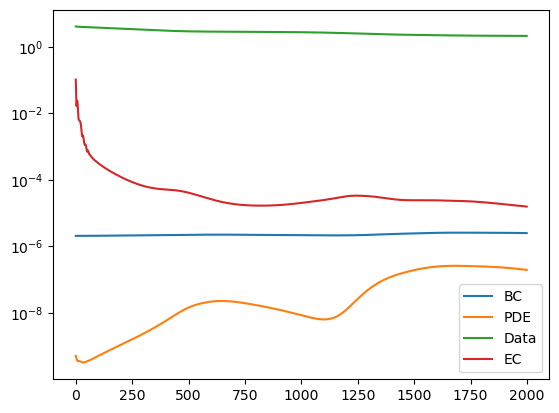

In [9]:
plt.plot(np.array(pinn.loss_history["BC"]),label="BC")
plt.plot(np.array(pinn.loss_history["PDE"]),label="PDE")
plt.plot(np.array(pinn.loss_history["Data"]),label="Data")
plt.plot(np.array(pinn.loss_history["EC"]),label="EC")
plt.yscale("log")
plt.legend()

In [99]:
loss_f=torch.nn.MSELoss( reduction="none")

<Axes: >

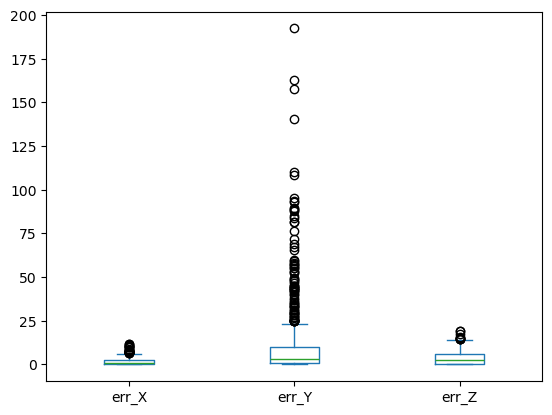

In [100]:
pd.DataFrame(loss_f(pinn(test_init_pos_main.to(pinn.device))[:,:3],test_disp_main.to(pinn.device)).detach().cpu().numpy(),columns=["err_X","err_Y","err_Z"]).plot(kind="box")

<Axes: >

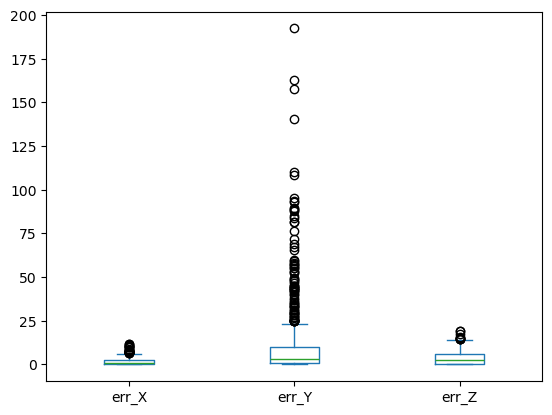

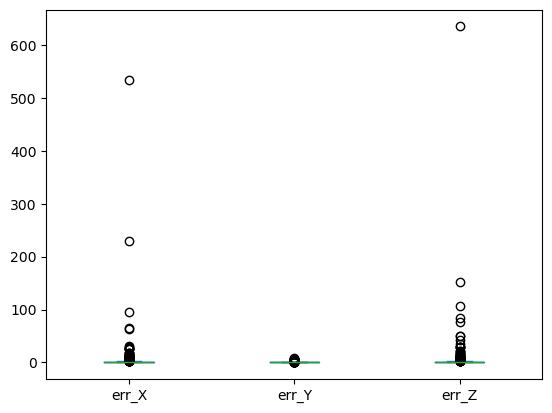

In [101]:
pd.DataFrame(loss_f(pinn(test_init_pos_main.to(pinn.device))[:,:3],test_disp_main.to(pinn.device)).detach().cpu().numpy(),columns=["err_X","err_Y","err_Z"]).plot(kind="box")
pd.DataFrame(torch.abs((pinn(test_init_pos_main.to(pinn.device))[:,:3]-test_disp_main.to(pinn.device))/test_disp_main.to(pinn.device)).cpu().detach().numpy(),columns=["err_X","err_Y","err_Z"]).plot(kind="box")
#plt.ylim([0,0.4])

In [102]:
rel_errs=torch.abs(pinn(test_init_pos_main.to(pinn.device))[:,:3]-test_disp_main.to(pinn.device)).cpu().detach().numpy()
rel_errs.shape

(699, 3)

In [86]:
px.scatter_3d(data.initialPosition_data_pd.filter(data.index_test,axis=0),x="X",y="Y",z="Z",color=rel_errs[:,0])

In [65]:
px.scatter_3d(data.initialPosition_data_pd.filter(data.index_test,axis=0),x="X",y="Y",z="Z",color=rel_errs[:,0])

In [66]:
px.scatter_3d(data.initialPosition_data_pd.filter(data.index_test,axis=0),x="X",y="Y",z="Z",color=rel_errs[:,1])

In [10]:
aux_plot=pd.concat([pd.DataFrame(test_init_pos_main.detach().cpu().numpy(),columns=["X","Y","Z"]),pd.DataFrame(test_disp_main.detach().cpu().numpy(),columns=["U","V","W"])],axis=1)
aux_plot["USUM"]=np.sqrt(aux_plot["U"]**2+aux_plot["V"]**2+aux_plot["W"]**2)
aux_plot

,X,Y,Z,U,V,W,USUM
0,31.232000,46.291000,24.742001,-0.091986,-9.32520,-3.023200,9.803446
1,30.290001,43.719002,56.403999,-2.500100,-7.75010,6.028900,10.132235
2,60.313999,34.235001,48.255001,3.476700,-3.51120,0.212390,4.945814
3,43.415001,41.755001,17.200001,1.621200,-11.77500,-4.124800,12.581450
4,61.271000,39.445999,39.814999,0.237160,-0.37026,-0.008344,0.439781
...,...,...,...,...,...,...,...
694,23.504999,54.852001,45.652000,-1.320700,-10.33900,4.979400,11.551346
695,46.765999,36.972000,56.868999,2.262300,-5.43330,5.488000,8.047167
696,26.614000,42.681999,55.636002,-3.495600,-7.58320,4.927000,9.695333
697,27.681999,47.522999,22.605000,-0.085430,-6.92600,-3.119300,7.596500


In [104]:
px.scatter_3d(aux_plot,x="X",y="Y",z="Z",color="USUM")

In [12]:
test_init_pos_main=test_init_pos_main.to("cuda")

In [13]:
aux_pred=pd.DataFrame(pinn(test_init_pos_main).detach().cpu().numpy()[:,:3],columns=["pred_U","pred_V","pred_W"])
aux_plot["pred_X"]=aux_plot["X"]+aux_pred["pred_U"]
aux_plot["pred_Y"]=aux_plot["Y"]+aux_pred["pred_V"]
aux_plot["pred_Z"]=aux_plot["Z"]+aux_pred["pred_W"]
aux_plot["real_X"]=aux_plot["X"]+aux_plot["U"]
aux_plot["real_Y"]=aux_plot["Y"]+aux_plot["V"]
aux_plot["real_Z"]=aux_plot["Z"]+aux_plot["W"]
aux_plot["dif_real_pred_X"]=aux_plot["real_X"]-aux_plot["pred_X"]
aux_plot["dif_real_pred_Y"]=aux_plot["real_Y"]-aux_plot["pred_Y"]
aux_plot["dif_real_pred_Z"]=aux_plot["real_Z"]-aux_plot["pred_Z"]
aux_plot["relativ_dif_real_pred_X"]=aux_plot["dif_real_pred_X"]/aux_plot["U"]
aux_plot["relativ_dif_real_pred_Y"]=aux_plot["dif_real_pred_Y"]/aux_plot["V"]
aux_plot["relativ_dif_real_pred_Z"]=aux_plot["dif_real_pred_Z"]/aux_plot["W"]

In [107]:
aux_plot

,X,Y,Z,U,V,W,USUM,pred_X,pred_Y,pred_Z,real_X,real_Y,real_Z,dif_real_pred_X,dif_real_pred_Y,dif_real_pred_Z,relativ_dif_real_pred_X,relativ_dif_real_pred_Y,relativ_dif_real_pred_Z
0,21.541000,32.111000,50.868000,-3.16850,-4.4672,1.06100,5.578619,20.483524,25.661955,54.731094,18.372501,27.643801,51.929001,-2.111023,1.981846,-2.802094,0.666253,-0.443644,-2.640993
1,34.953999,38.198002,33.967999,-0.42156,-5.5849,0.54902,5.627632,34.604332,29.281643,35.931824,34.532440,32.613102,34.517017,-0.071892,3.331459,-1.414806,0.170538,-0.596512,-2.576967
2,36.743999,52.448002,47.762001,-0.25608,-14.2900,6.36480,15.645458,35.365738,44.671234,51.629227,36.487919,38.158001,54.126801,1.122181,-6.513233,2.497574,-4.382150,0.455790,0.392404
3,34.462002,51.463001,24.851999,1.03120,-13.8690,-4.98340,14.773179,34.033379,38.834568,22.275673,35.493202,37.594002,19.868599,1.459824,-1.240566,-2.407074,1.415655,0.089449,0.483018
4,35.549999,45.105000,53.606998,-0.91314,-8.5776,6.85040,11.015308,34.436726,38.422928,57.473110,34.636860,36.527401,60.457397,0.200134,-1.895527,2.984287,-0.219172,0.220986,0.435637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,31.146000,42.557999,17.337999,-2.31760,-11.6860,-3.49270,12.415024,31.155134,31.146881,14.534986,28.828400,30.871998,13.845299,-2.326735,-0.274883,-0.689688,1.003941,0.023522,0.197465
695,56.324001,48.896000,52.023998,3.35480,-7.0280,4.17630,8.836795,56.828415,42.844379,53.609329,59.678802,41.868000,56.200298,2.850388,-0.976379,2.590969,0.849645,0.138927,0.620398
696,34.841999,35.325001,45.012001,-0.80273,-4.2467,3.65810,5.662202,34.502537,31.937395,48.747601,34.039268,31.078300,48.670101,-0.463268,-0.859095,-0.077499,0.577116,0.202297,-0.021186
697,41.088001,41.652000,17.219000,0.80935,-12.2460,-4.33180,13.014763,41.893581,32.721855,14.107635,41.897350,29.406000,12.887199,0.003769,-3.315855,-1.220436,0.004657,0.270770,0.281739


In [108]:
px.scatter_3d(aux_plot,x="real_X",y="real_Y",z="real_Z",color="USUM")

In [109]:
px.scatter_3d(aux_plot,x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

In [110]:
px.scatter_3d(aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"]>0.1],x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

In [14]:
# Crear una figura con subplots
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Añadir el primer gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot['real_X'],
    y=aux_plot['real_Y'],
    z=aux_plot['real_Z'],
    mode='markers',
    marker=dict(size=12, color=aux_plot['USUM']),
    name='Real'
), row=1, col=1)

# Añadir el segundo gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot['pred_X'],
    y=aux_plot['pred_Y'],
    z=aux_plot['pred_Z'],
    mode='markers',
    marker=dict(size=12, color=aux_plot['USUM']),
    name='Predicción'
), row=1, col=2)

# Añadir el tercer gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.1, 'pred_X'],
    y=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.1, 'pred_Y'],
    z=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.1, 'pred_Z'],
    mode='markers',
    marker=dict(size=12, color=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.1, 'USUM']),
    name='Predicción con Diferencia > 0.1'
), row=1, col=3)

# Actualizar el layout de la figura
fig.update_layout(height=600, width=1800, title_text="Comparación de Gráficos 3D")

# Mostrar la figura
fig.show()


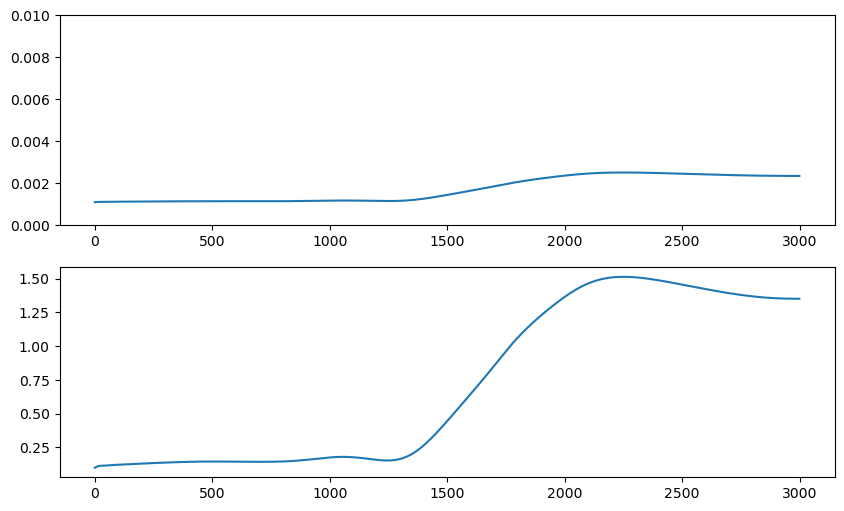

In [111]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot([i.item() for i in pinn.params_history["E"]])
plt.ylim([0,0.01])
plt.subplot(2,1,2)
plt.plot([i.item() for i in pinn.params_history["alpha"]])

---
# Pruebecillas GNN

In [1]:
import networkx as nx 

In [2]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [27]:
aux = f"{data.base_dir}/ARTURO_TEST_1/ELEMENT.txt"
with open(aux,"r") as f:
    aux_list=f.readlines()
aux2=[i for i in aux_list if keep_line(i)]
aux3=[i.strip("\n") for i in aux2]
aux4=[i.split() for i in aux3]

aux5=np.array(aux4).astype(int)[:,-8:]-1
AM=np.zeros((aux5.max()+1,aux5.max()+1))
print(AM.shape)

(4151, 4151)


In [8]:
for i in aux4:
    for j in i:
        AM[i,j]=1

In [9]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [10]:
check_symmetric(AM)

True

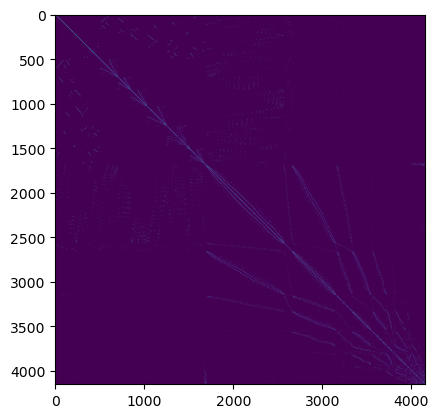

In [11]:
plt.imshow(AM)

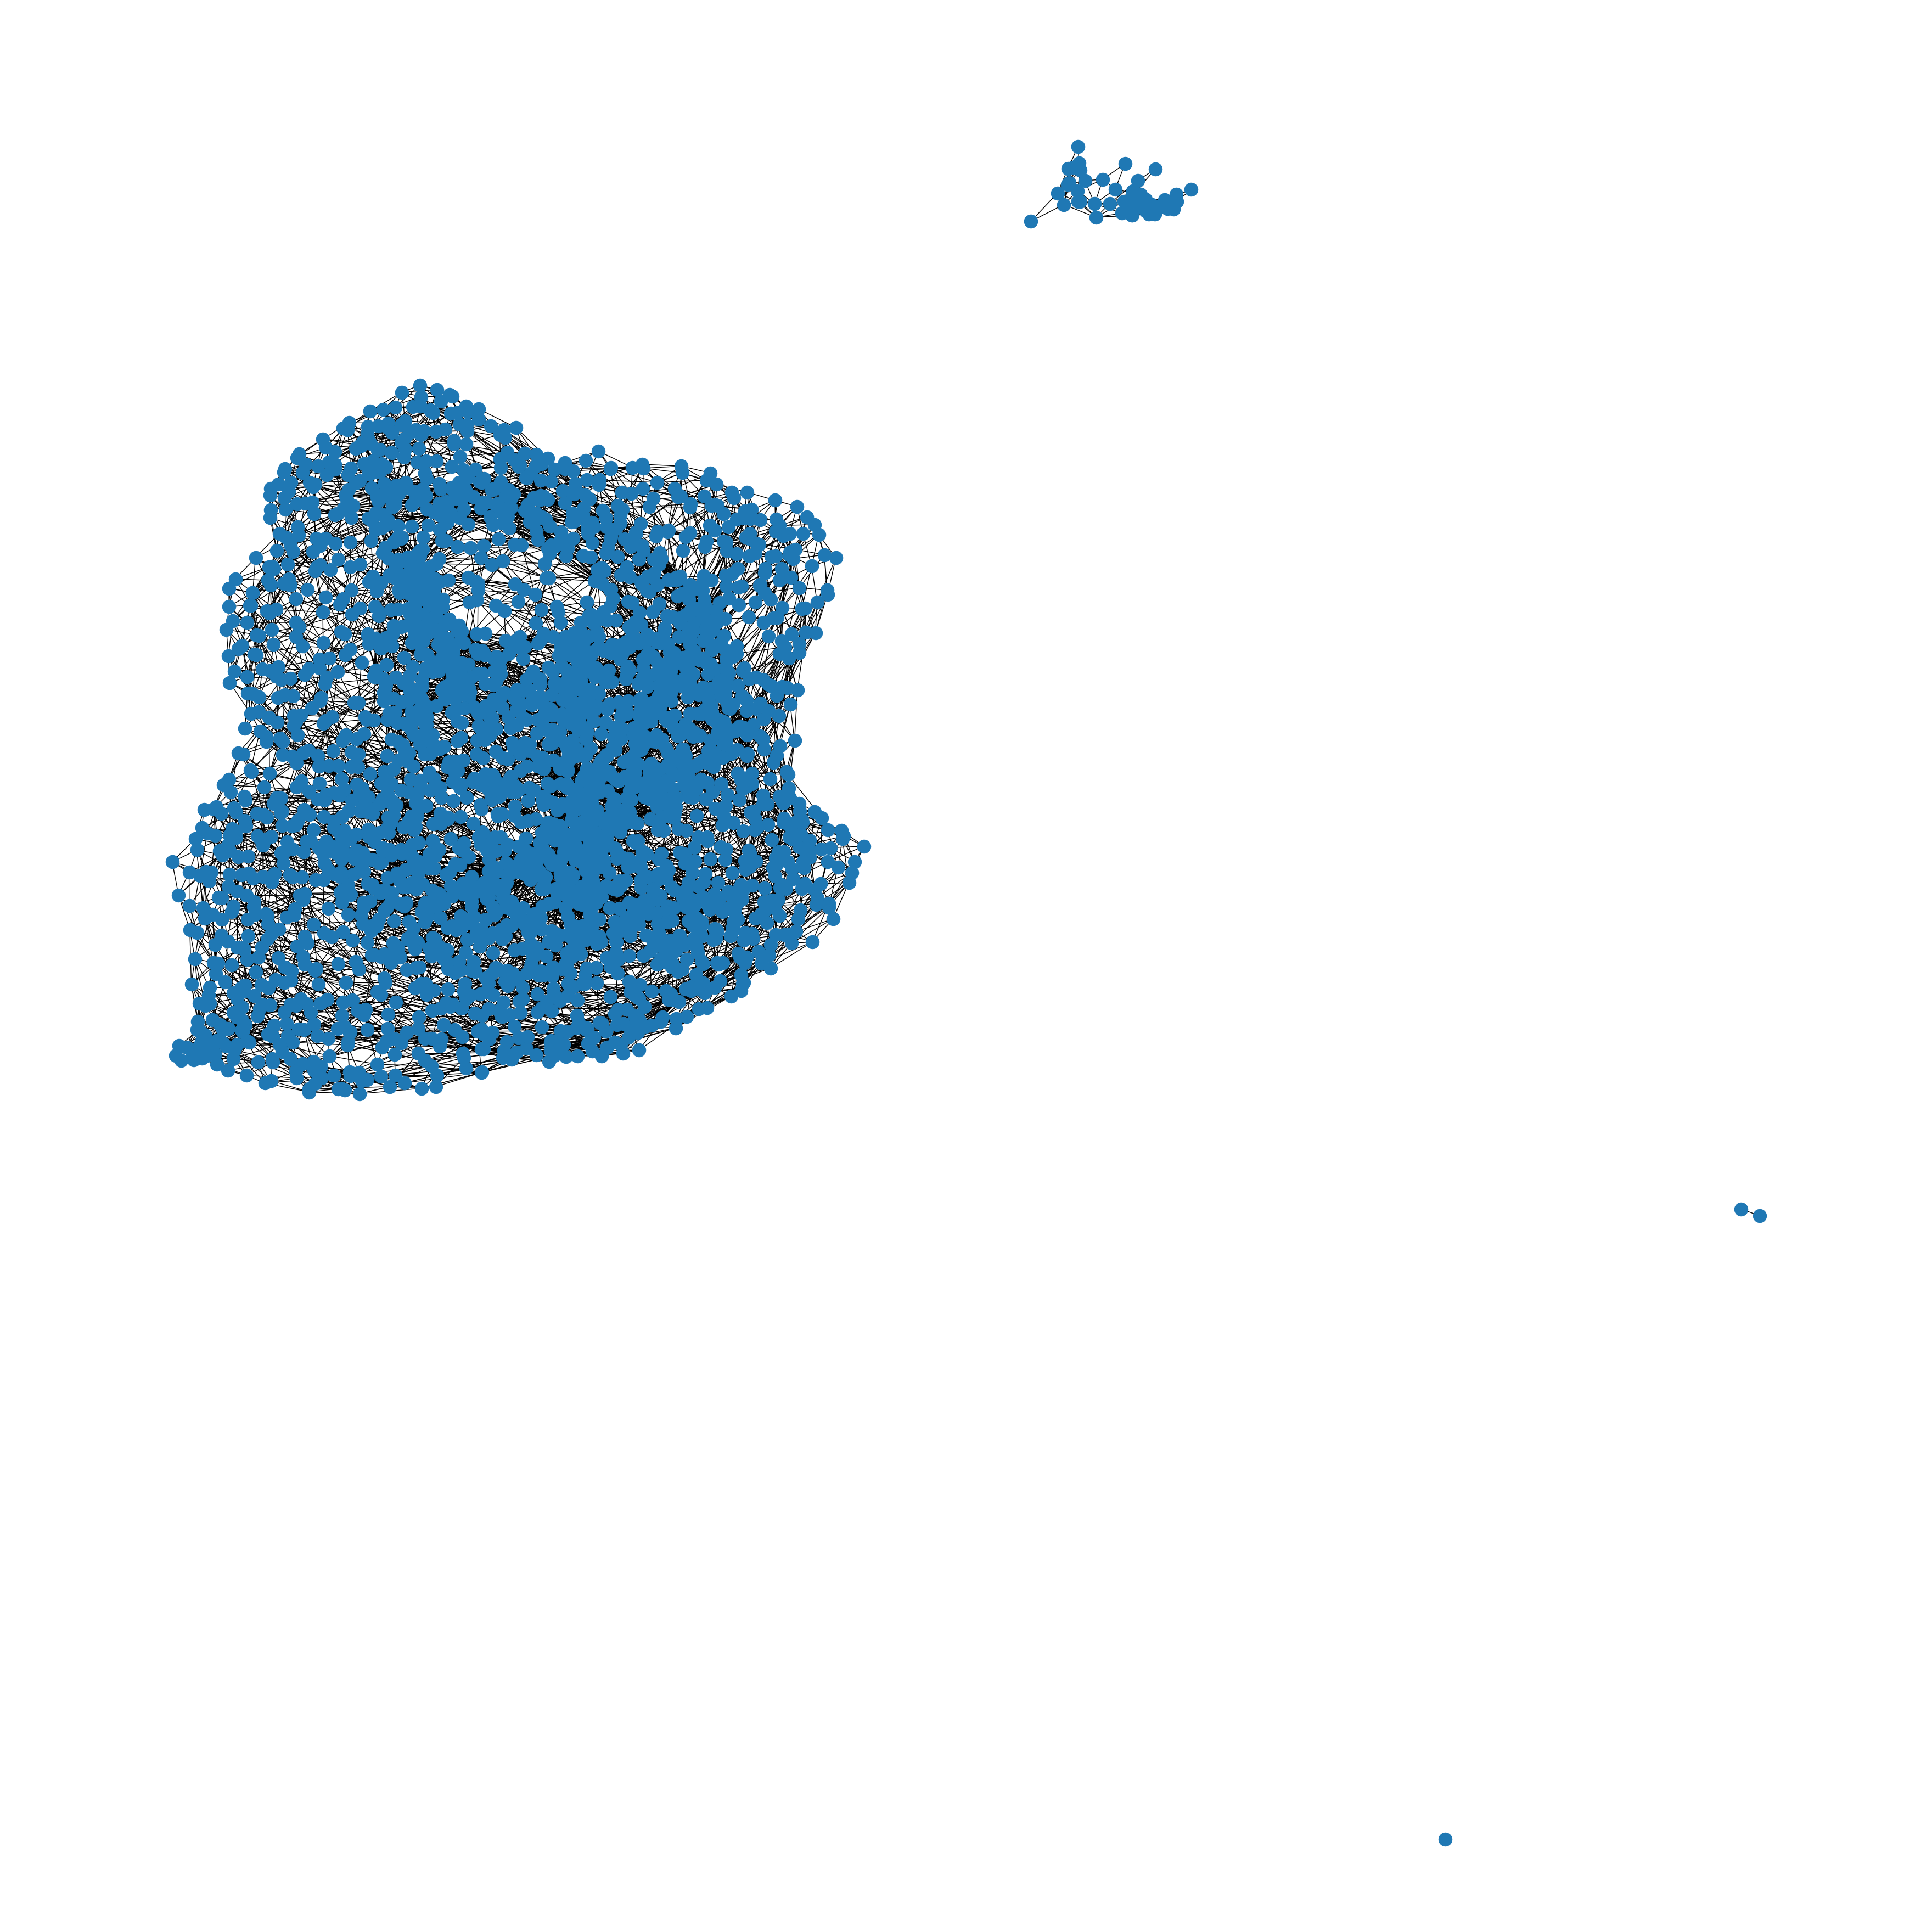

In [23]:
graph = nx.from_numpy_array(AM[:3000,:3000]-np.eye(3000,3000))

# Draw the graph
plt.figure(figsize=(35,35))
nx.draw(graph, with_labels=False)

In [35]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    #nx.draw_networkx_labels(graph,pos)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph g has nodes and edges entered
save_graph(graph,"my_graph.pdf")
